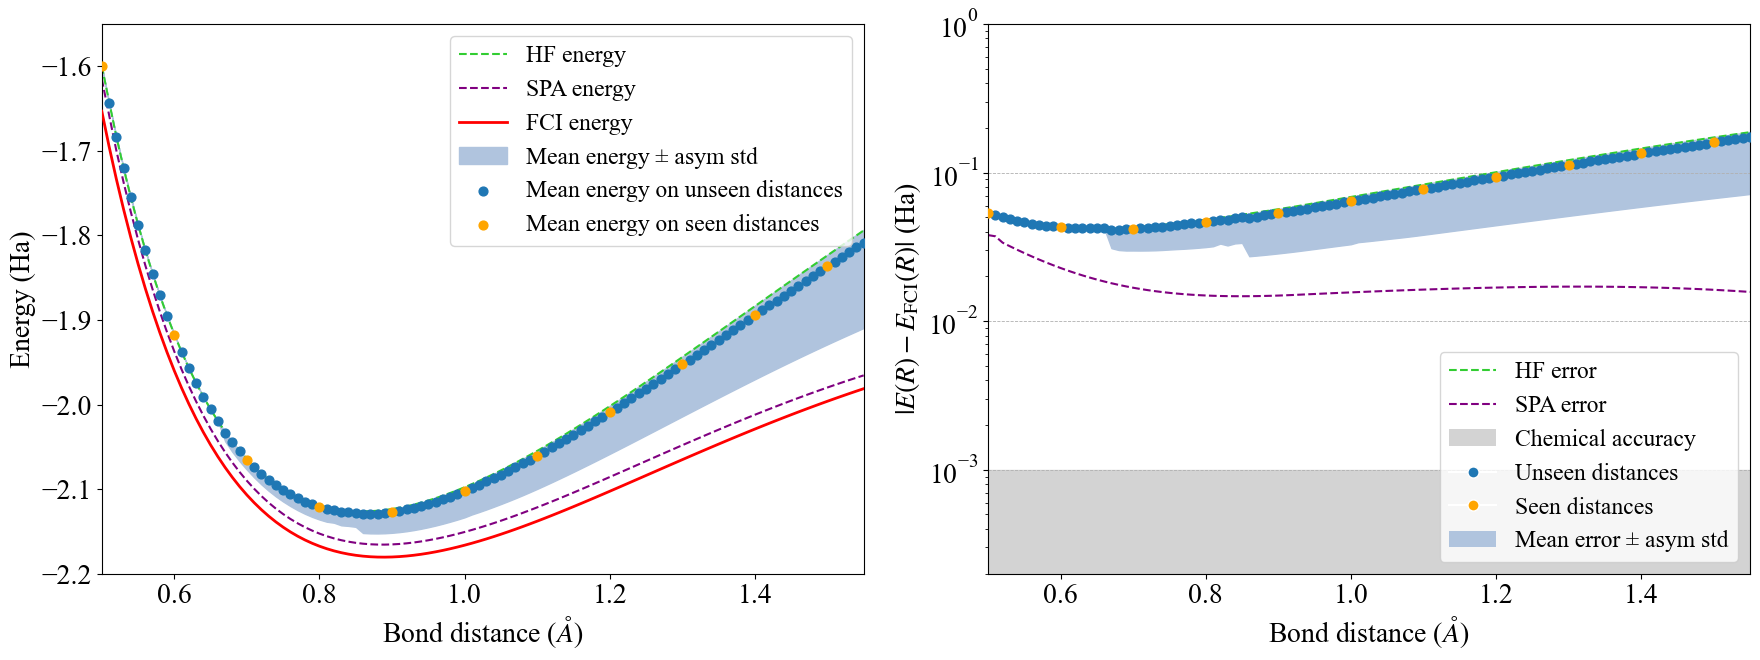

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from collections import defaultdict

chemical_accuracy = 0.001
rcParams['font.size'] = 20
rcParams['font.family'] = 'Times New Roman'
rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["figure.figsize"] = (18, 7)

bond_distance, fci_energy, hf_energy, spa_energy = np.load("h4_info.npy", allow_pickle=True)
bond_distance=bond_distance[0:-7]
fci_energy=fci_energy[0:-7]
hf_energy=hf_energy[0:-7]
spa_energy =spa_energy [0:-7]

hf_error=hf_energy-fci_energy
spa_error=spa_energy-fci_energy


all_pred_bd        = []
all_pred_energies  = []
seen_bd_set        = set()


for session in range(12):
    unseen_results = np.load(f'training_session_{session}/unseen_prediction_{session}.npy', allow_pickle=True)
    results        = np.load(f'training_session_{session}/results_{session}.npy', allow_pickle=True)

  
    bd_seen = np.array(list(zip(*results))[6])[:-7]

    
    pred_energies = np.array(list(zip(*unseen_results))[0])[:-7]
    pred_bd       = np.round(np.array(list(zip(*unseen_results))[3]), 2)[:-7]  # auf 2 Nachkommastellen runden

 
    all_pred_bd.extend(pred_bd)
    all_pred_energies.extend(pred_energies)
    seen_bd_set.update(np.round(bd_seen, 2))


all_pred_bd       = np.asarray(all_pred_bd)
all_pred_energies = np.asarray(all_pred_energies)


unique_bd = np.unique(all_pred_bd)

mean_energies   = np.empty_like(unique_bd, dtype=float)
std_energies    = np.empty_like(unique_bd, dtype=float)
asym_std_lower  = np.empty_like(unique_bd, dtype=float)
asym_std_upper  = np.empty_like(unique_bd, dtype=float)


for i, bdd in enumerate(unique_bd):
    idx  = np.where(all_pred_bd == bdd)[0]
    vals = all_pred_energies[idx]
    mu   = vals.mean()

    mean_energies[i] = mu
    std_energies[i]  = vals.std()


    below = vals[vals < mu]
    above = vals[vals > mu]

    asym_std_lower[i] = (
        np.sqrt(np.sum((mu - below) ** 2) / (len(below) - 1))
        if len(below) > 1 else (abs(below[0] - mu) if len(below) == 1 else 0.0)
    )
    asym_std_upper[i] = (
        np.sqrt(np.sum((above - mu) ** 2) / (len(above) - 1))
        if len(above) > 1 else (abs(above[0] - mu) if len(above) == 1 else 0.0)
    )

error=mean_energies-fci_energy

mask  = np.isin(unique_bd, list(seen_bd_set))
maskf = ~mask 

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 7), sharex=False)

# PEC
ax1.plot(bond_distance, hf_energy,  label="HF energy",  linestyle="--", color="limegreen", zorder=1)
ax1.plot(bond_distance, spa_energy, label="SPA energy", linestyle="--", color="purple",    zorder=2)
ax1.plot(bond_distance, fci_energy, label="FCI energy", linestyle="-",  color="red",     zorder=3, linewidth=2)

ax1.fill_between(pred_bd,
                 mean_energies - asym_std_lower,
                 mean_energies + asym_std_upper,
                 color='lightsteelblue', alpha=1, label="Mean energy ± asym std", zorder=0)


ax1.scatter(pred_bd[maskf], mean_energies[maskf], s=40, color='#1f77b4', label='Mean energy on unseen distances', zorder=4)
ax1.scatter(pred_bd[mask],  mean_energies[mask],  s=40, color='orange',  label='Mean energy on seen distances',  zorder=4)

ax1.set_ylim(-2.2, -1.55)
ax1.set_xlim(pred_bd[0], 1.55)
ax1.set_xlabel("Bond distance ($\\AA$)")
ax1.set_ylabel("Energy (Ha)")
ax1.legend(fontsize=17, loc='upper right')

# Error plot
ax2.plot(bond_distance, hf_error,  color='limegreen', linestyle="--", label='HF error',  zorder=3)
ax2.plot(bond_distance, spa_error, color='purple',    linestyle="--", label='SPA error', zorder=2)


ax2.fill_between(pred_bd, 0, chemical_accuracy, color='lightgrey', alpha=1, zorder=-10)


ax2.fill_between(pred_bd,
                 error - asym_std_lower,
                 error + asym_std_upper,
                 color='lightsteelblue', alpha=1, label="Mean error ± asym std", zorder=1)


ax2.scatter(pred_bd[maskf], error[maskf], s=40, color='#1f77b4', label='Mean error on unseen distances', zorder=4)
ax2.scatter(pred_bd[mask],  error[mask],  s=40, color='orange',  label='Mean error on seen distances',  zorder=4)

ax2.set_yscale("log")
ax2.set_ylim(2e-4, 1)
ax2.set_xlim(pred_bd[0], pred_bd[-1])
ax2.set_xlabel("Bond distance ($\\AA$)")
ax2.set_ylabel("$|E(R)-E_{\\mathrm{FCI}}(R)|$ (Ha)")
ax2.grid(True, axis='y', linestyle="--", linewidth=0.6)


legend_elements = [
    Line2D([0], [0], linestyle='--', color='limegreen', label='HF error'),
    Line2D([0], [0], linestyle='--', color='purple',    label='SPA error'),
    Rectangle((0, 0), 1, 1, fc="lightgrey", alpha=1, label="Chemical accuracy"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=8, label='Unseen distances'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange',  markersize=8, label='Seen distances'),
    Rectangle((0, 0), 1, 1, fc="lightsteelblue", alpha=1, label="Mean error ± asym std")
]
ax2.legend(handles=legend_elements, fontsize=17, loc='lower right')


plt.tight_layout()
plt.savefig("combined_energy_and_error_plot_stats.png", dpi=300, bbox_inches="tight")
plt.show()


/var/folders/kw/wfwn4ymn26j7pzm9g8tp9vj80000gn/T/ipykernel_6467/1332319352.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


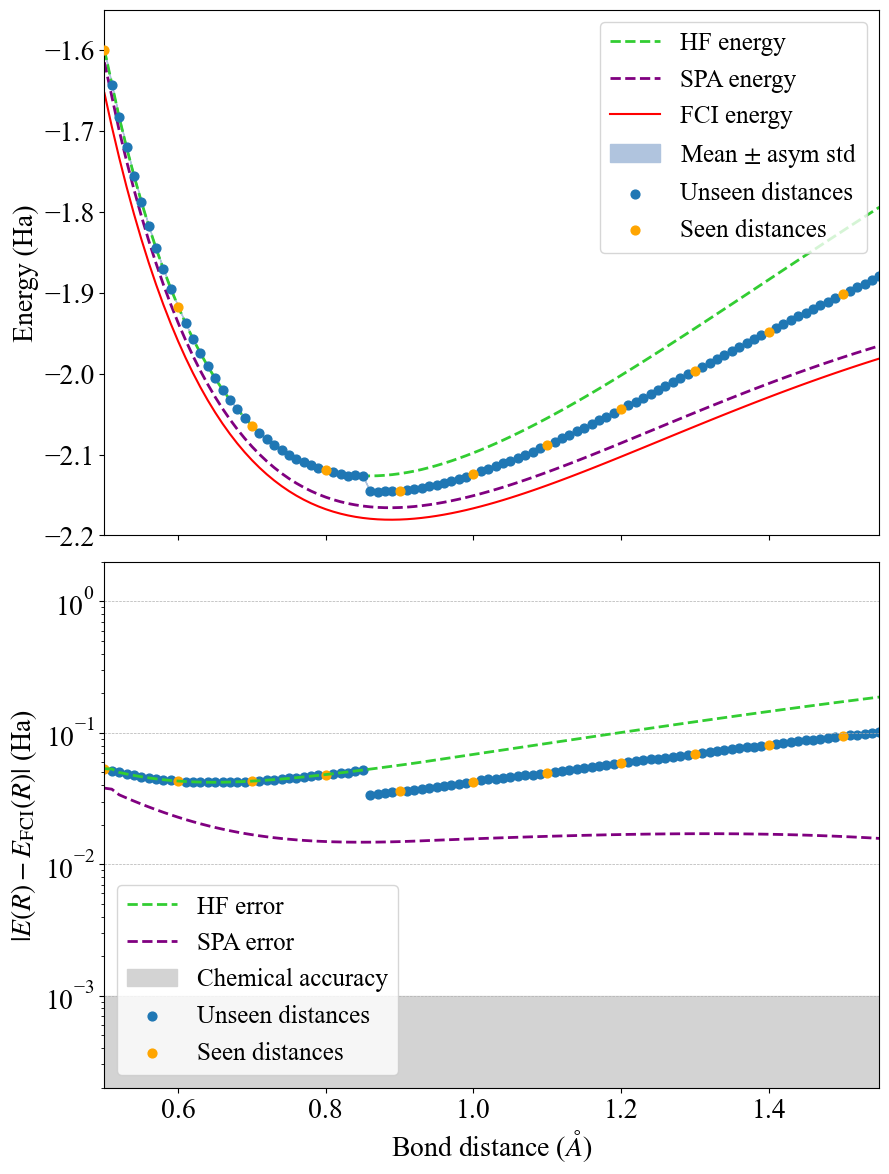

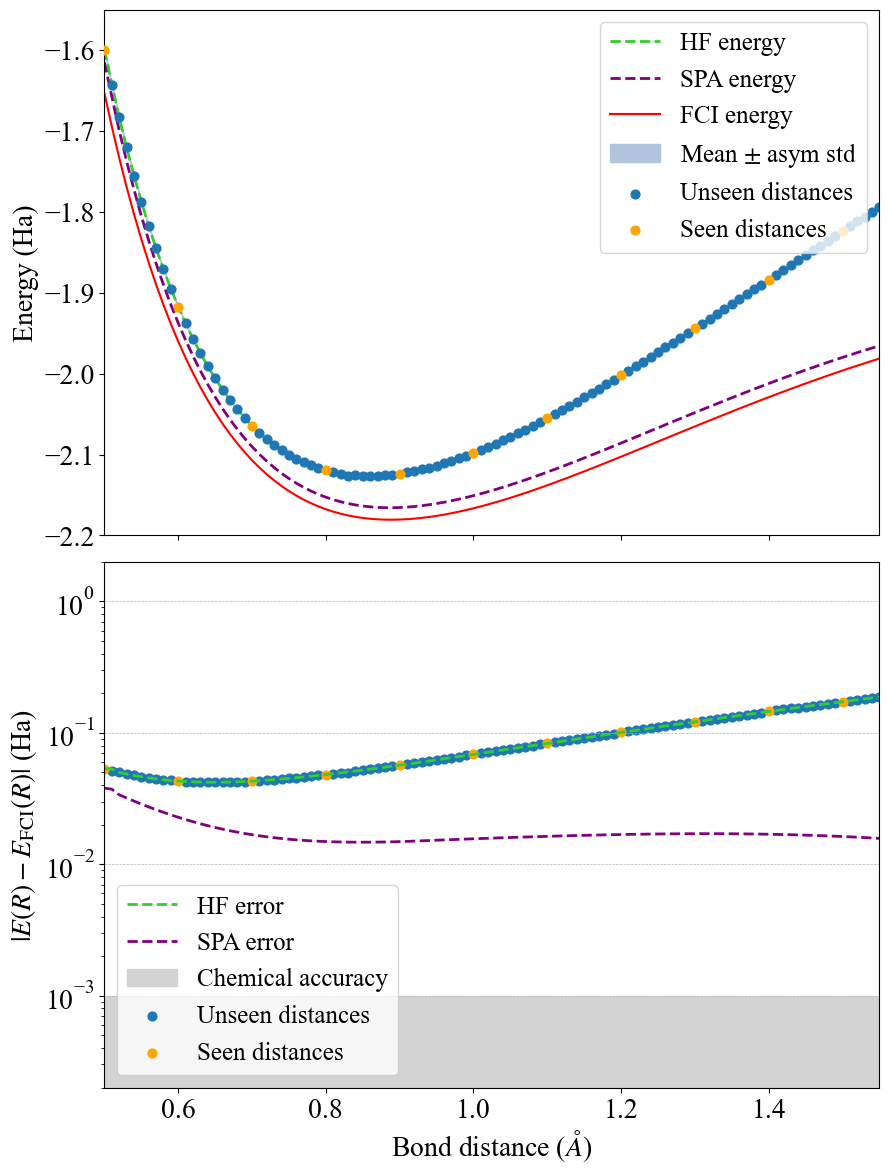

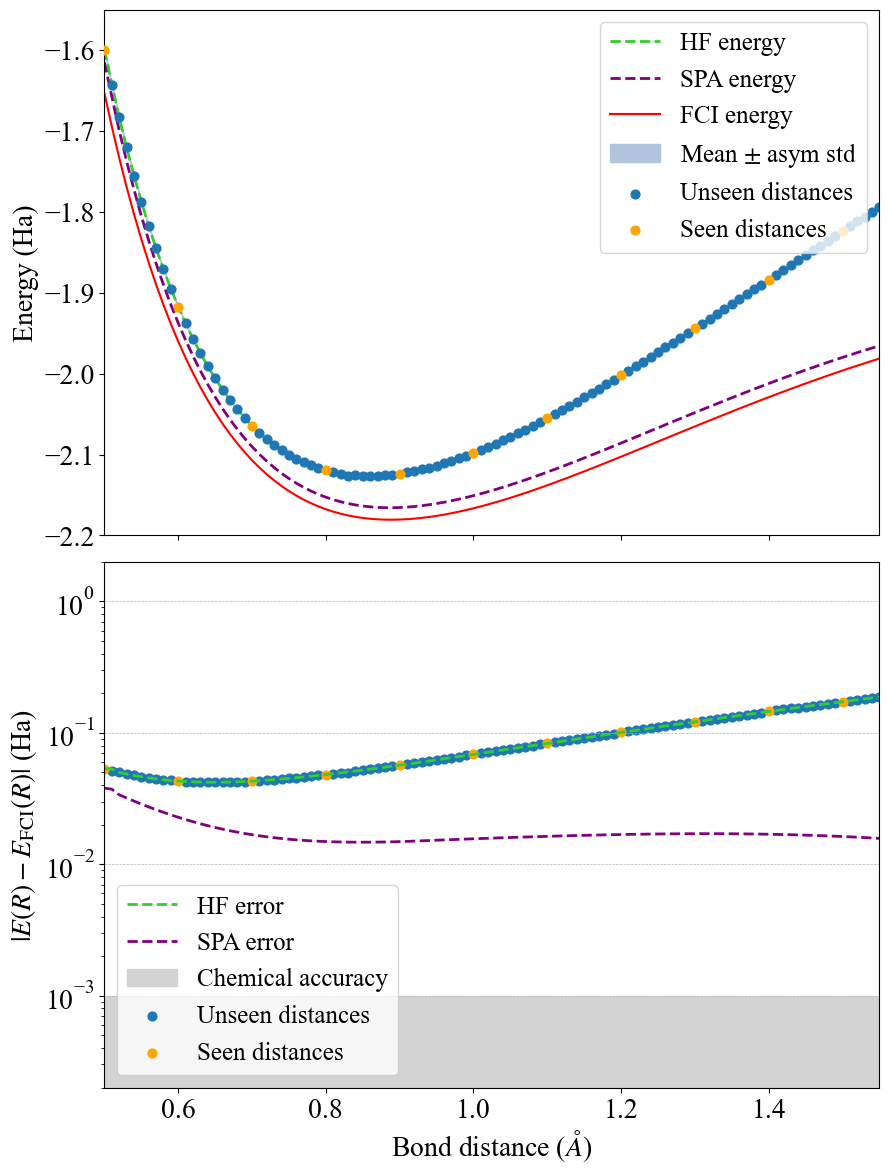

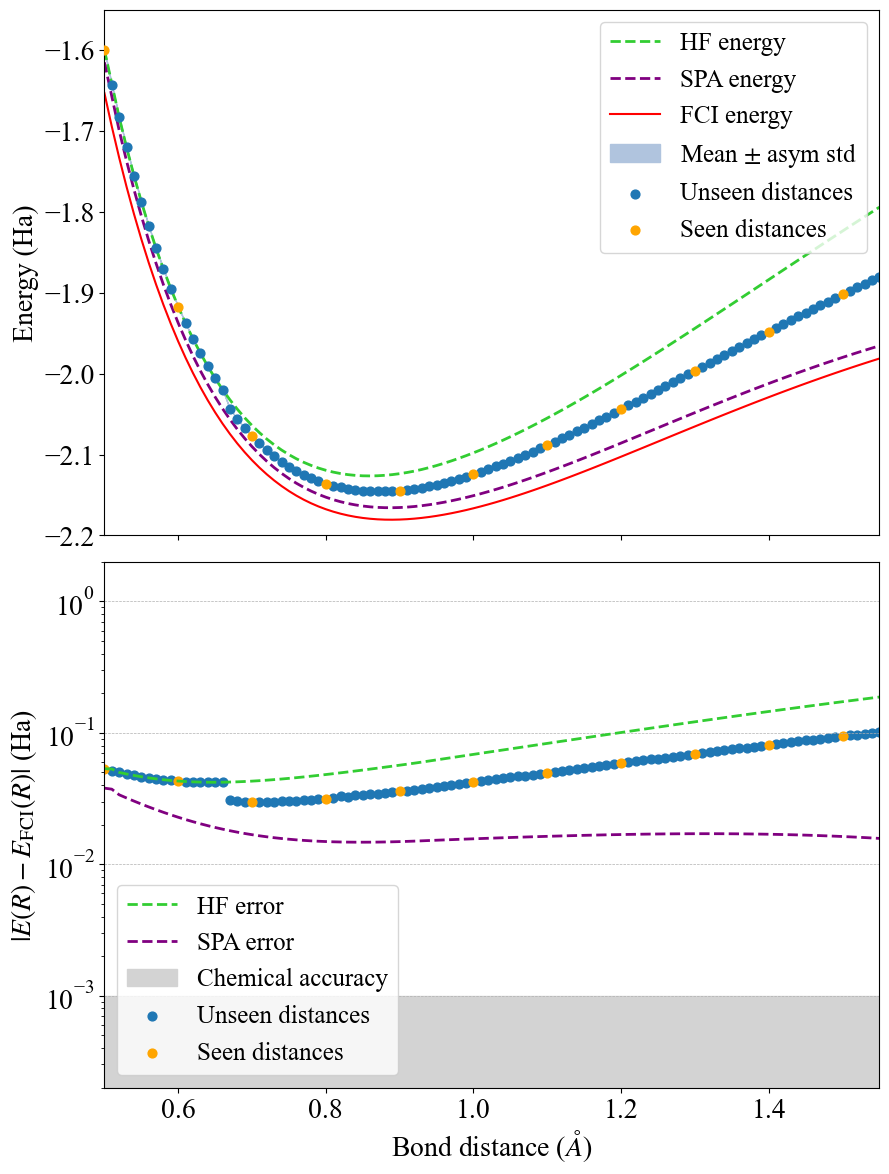

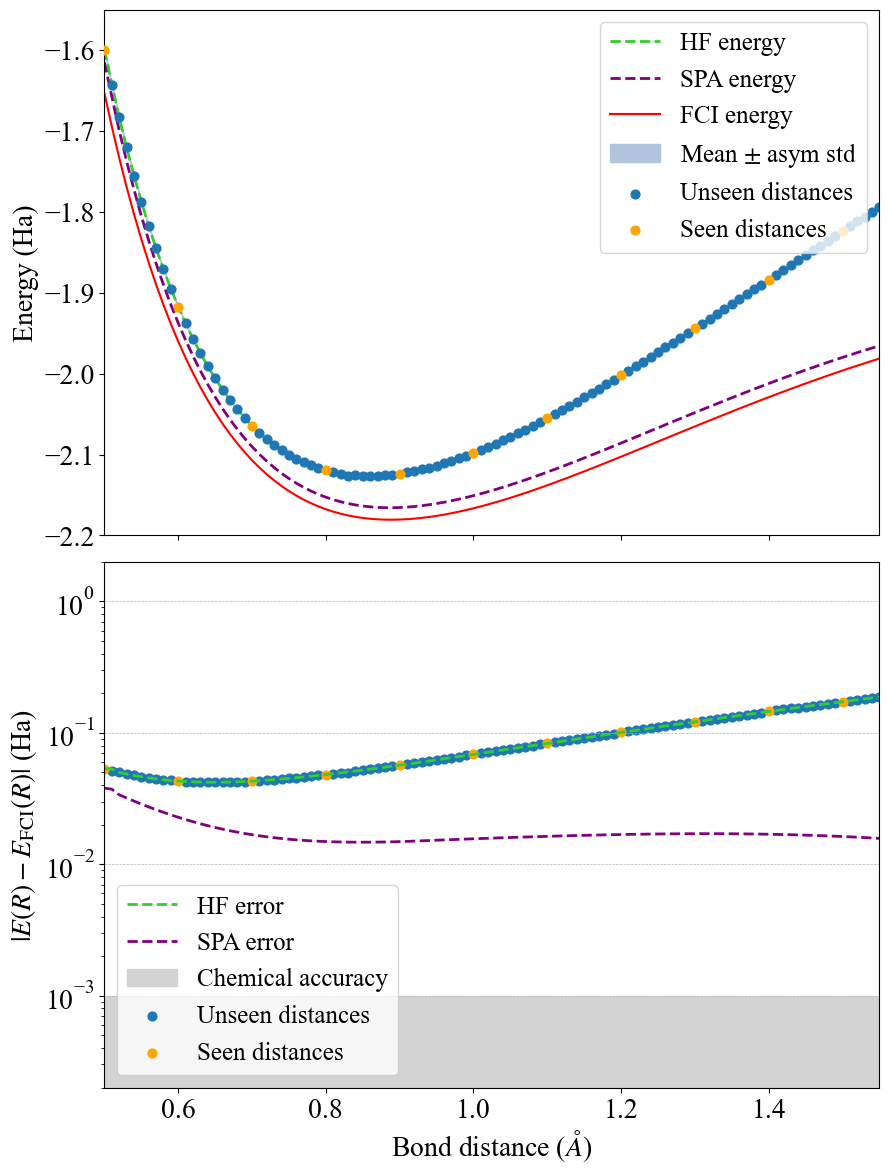

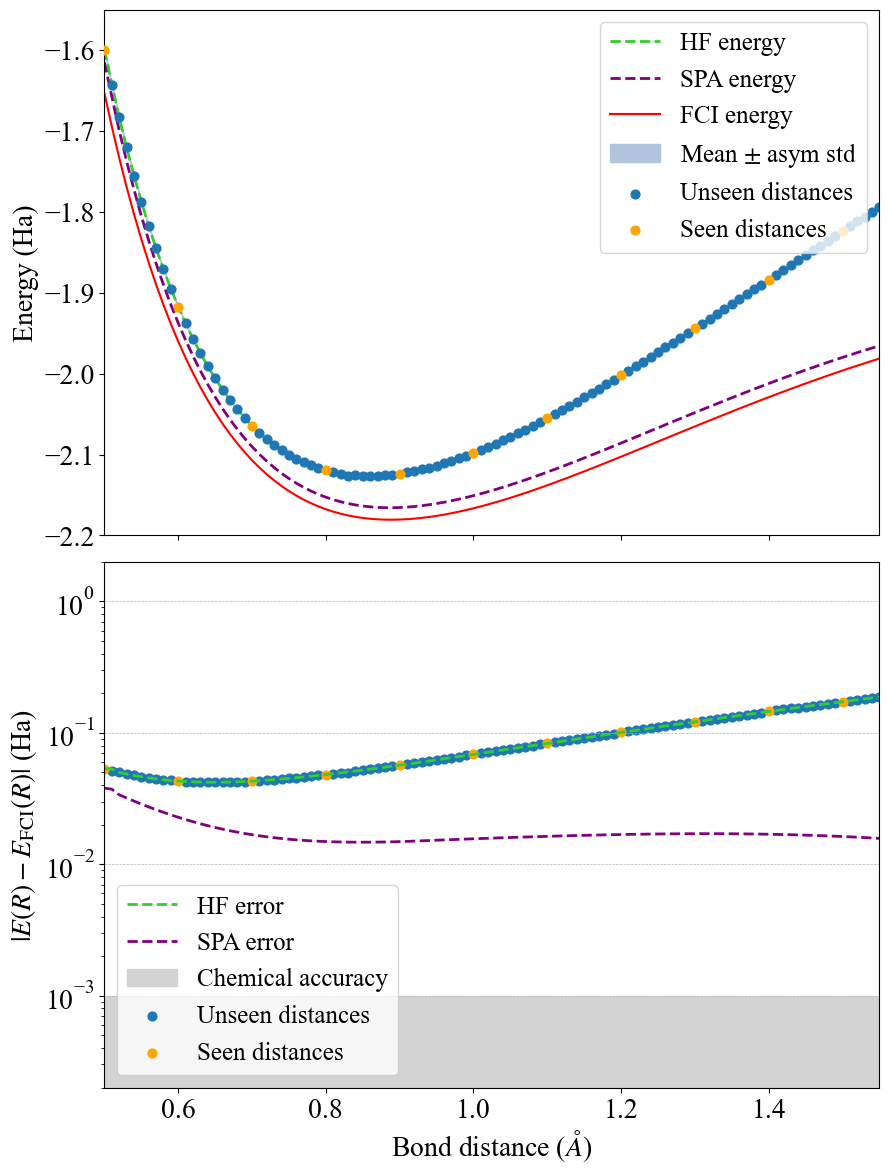

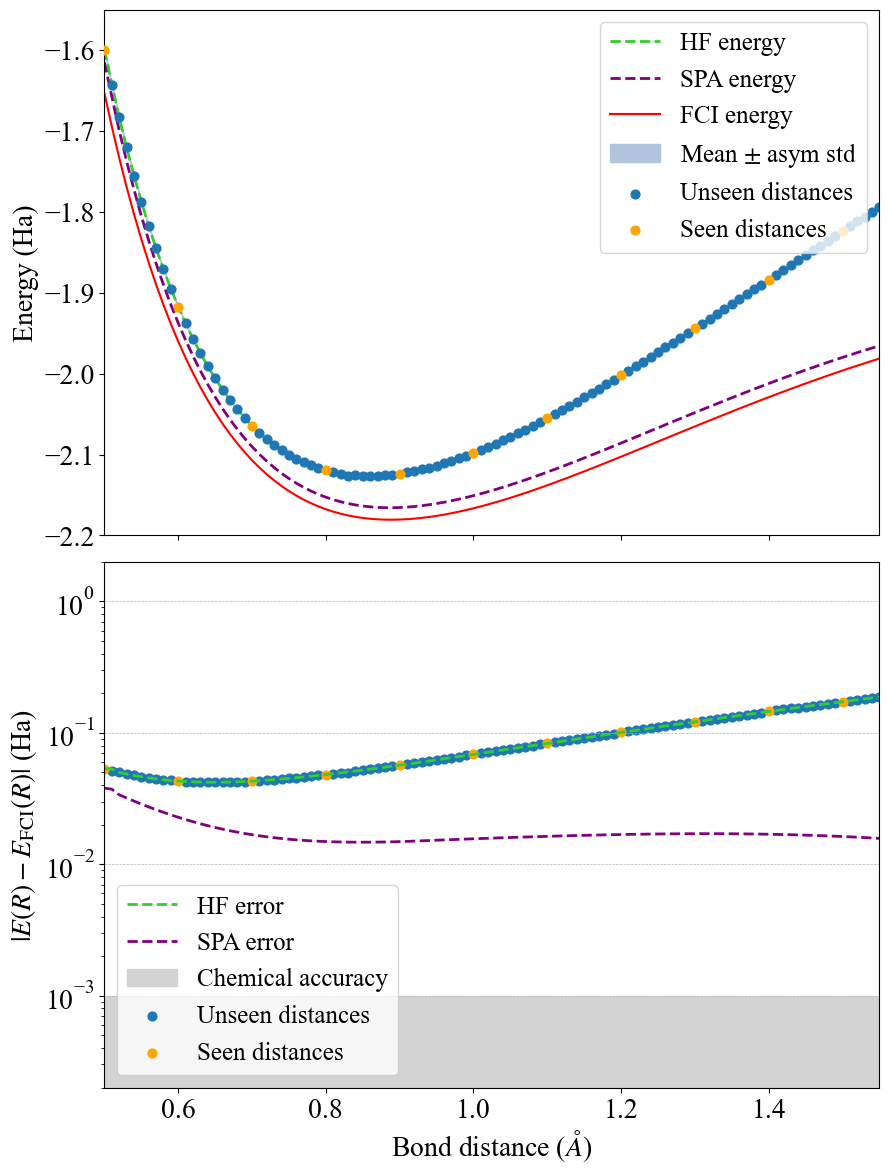

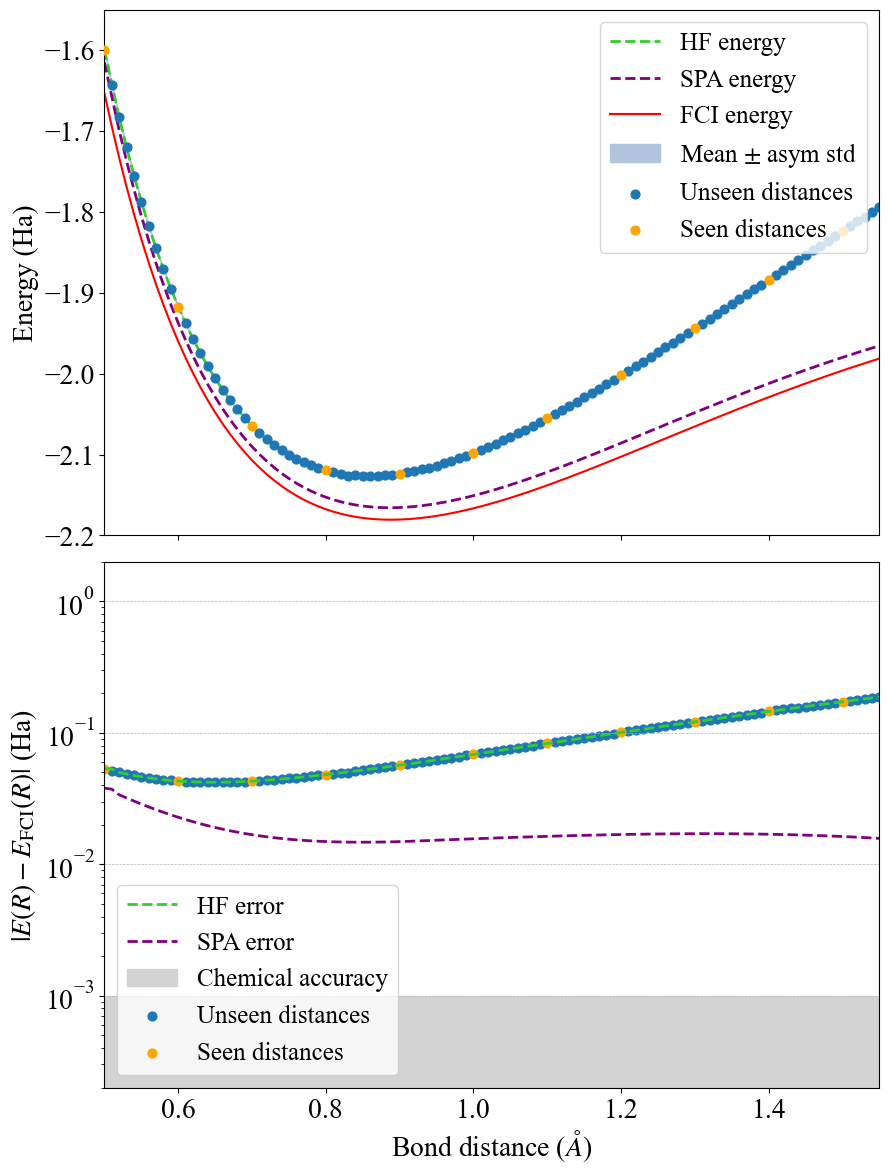

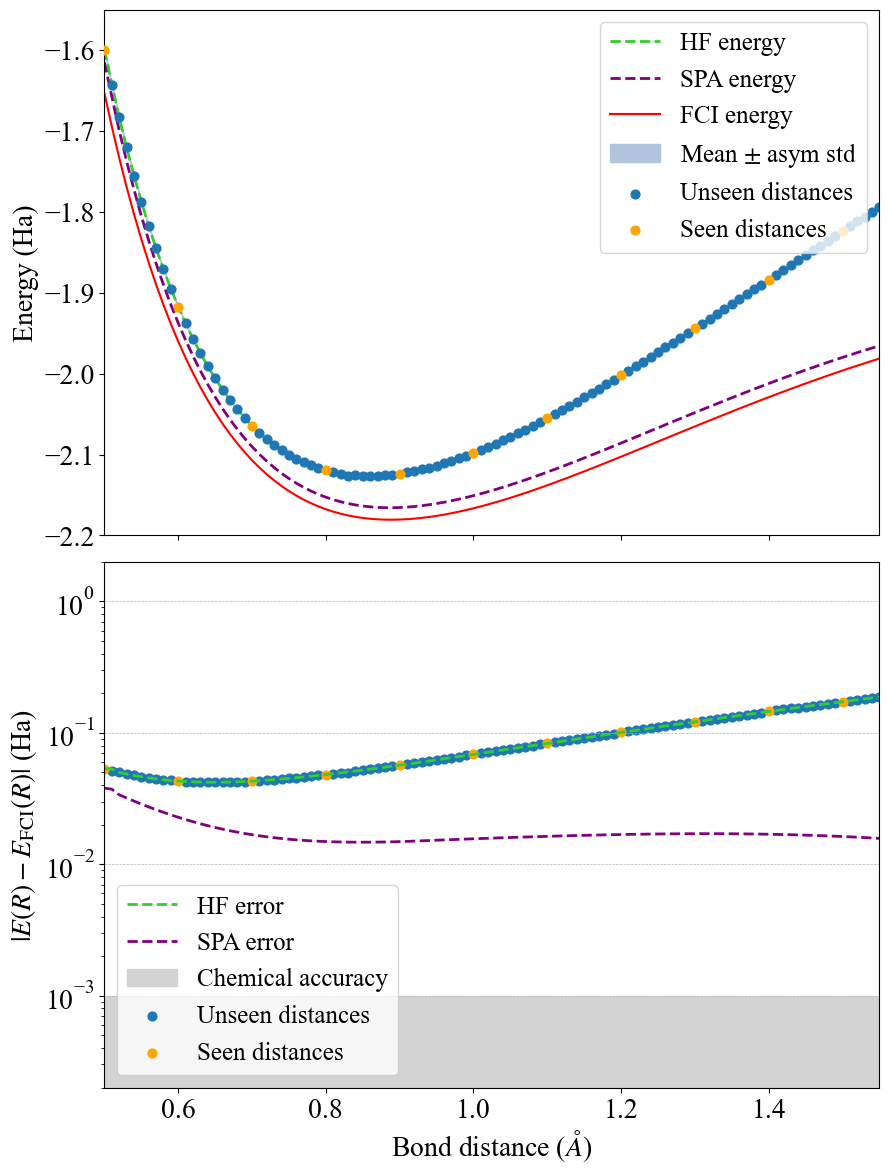

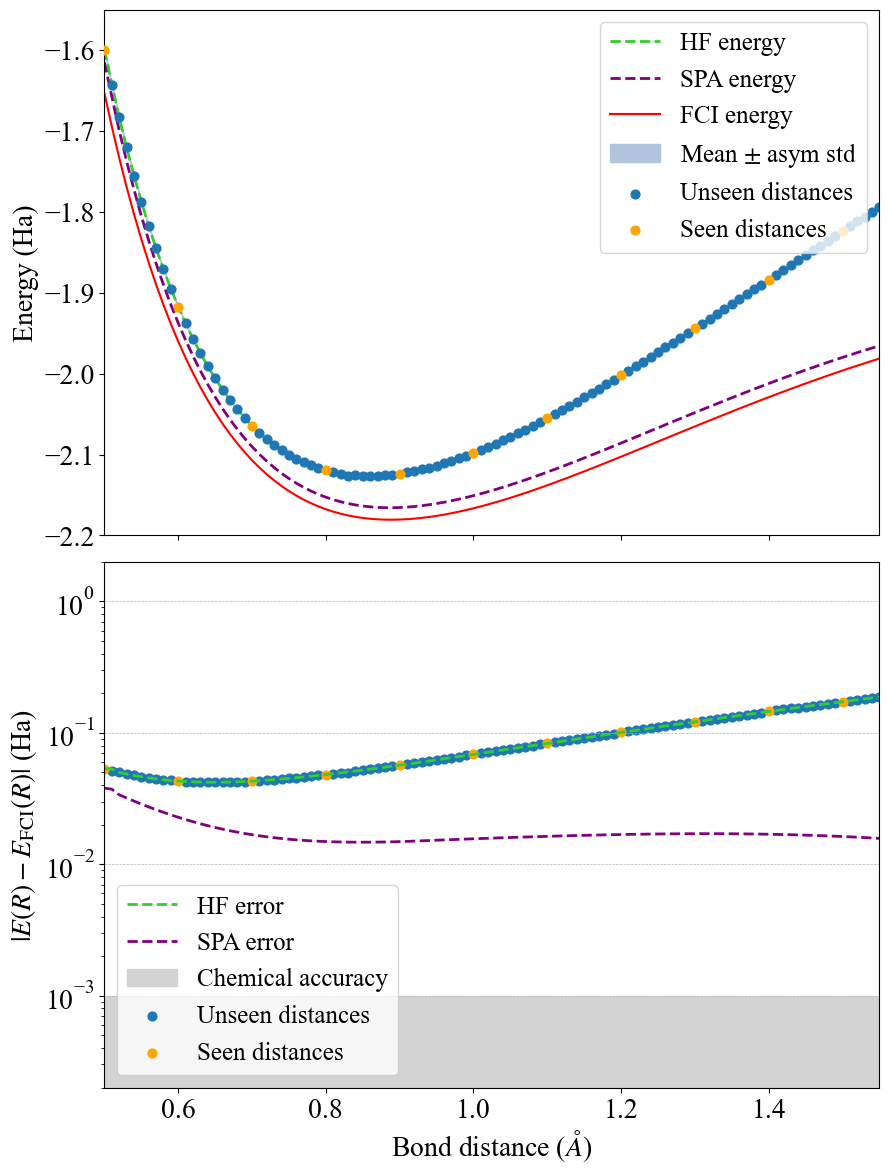

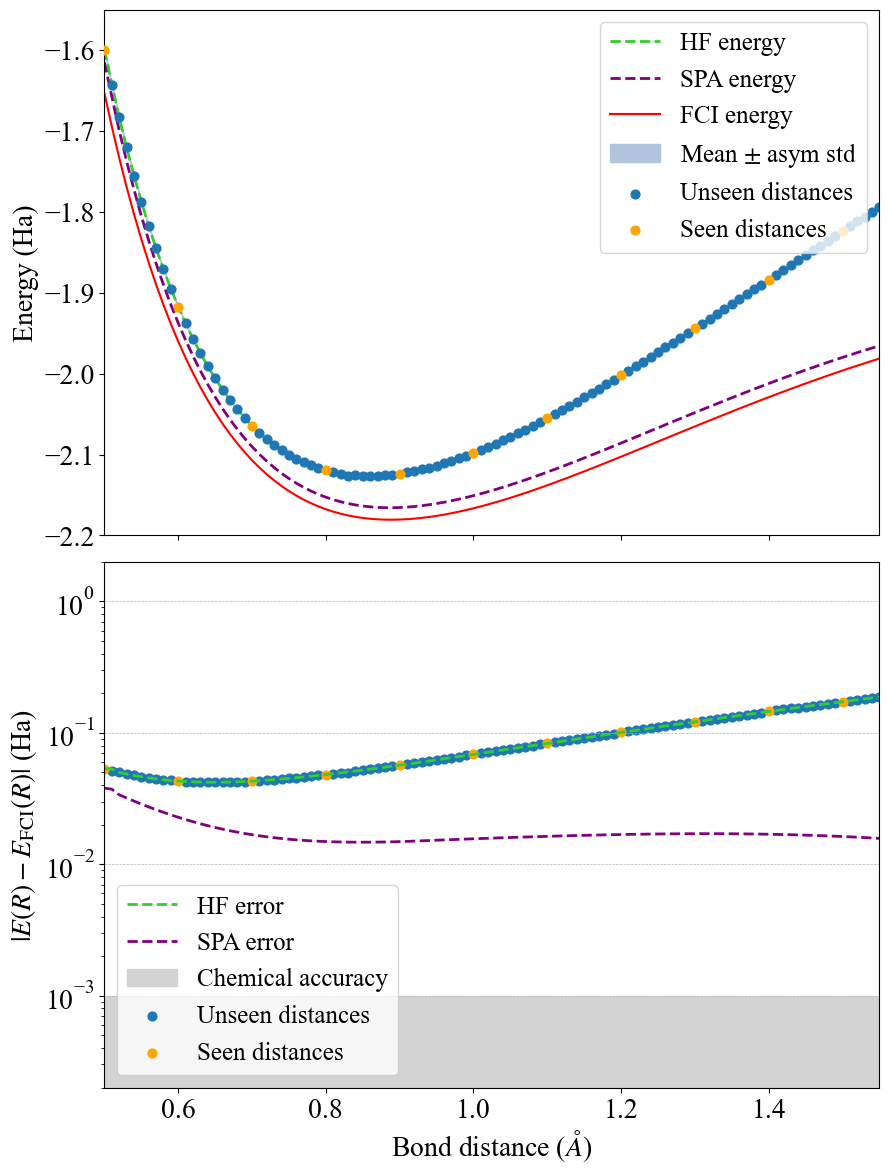

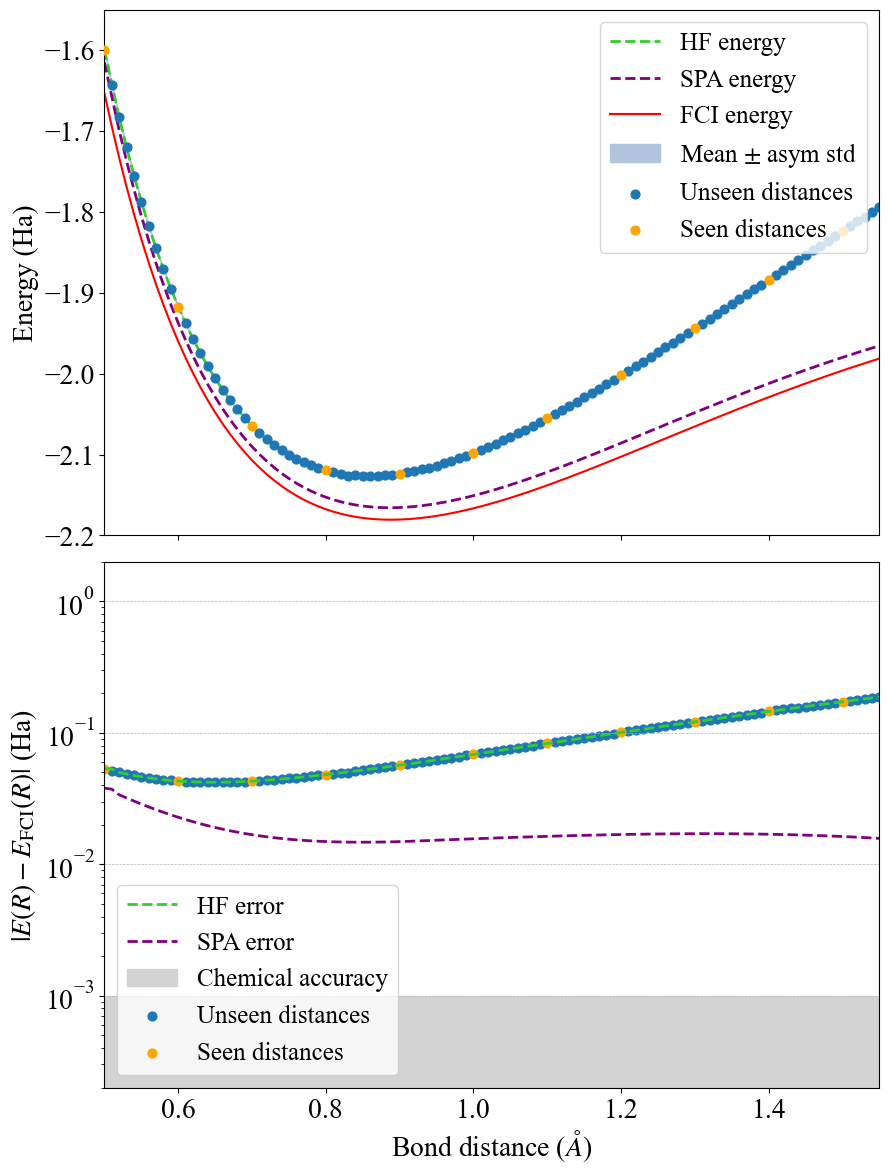

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams



chemical_accuracy = 0.001


rcParams['font.size'] = 20
rcParams['font.family'] = 'Times New Roman'
rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["figure.figsize"] = (10, 14)

bond_distance, fci_energy, hf_energy, spa_energy = np.load("h4_info.npy", allow_pickle=True)

bond_distance=bond_distance[0:-7]
fci_energy=fci_energy[0:-7]
hf_energy=hf_energy[0:-7]
spa_energy =spa_energy [0:-7]

for session in range(12):
    unseen_results = np.load(f'training_session_{session}/unseen_prediction_{session}.npy', allow_pickle=True)
    results        = np.load(f'training_session_{session}/results_{(session)}.npy', allow_pickle=True)

    pred_energies = np.array(list(zip(*unseen_results))[0])[:-7]
    pred_bd       = np.round(np.array(list(zip(*unseen_results))[3]), 3)[:-7]
    seen_bd       = np.round(np.array(list(zip(*results))[6]), 3)


    mask_seen   = np.isin(pred_bd, seen_bd)
    mask_unseen = ~mask_seen


    error     = np.abs(pred_energies - fci_energy)
    hf_error  = np.abs(hf_energy - fci_energy)
    spa_error = np.abs(spa_energy - fci_energy)


    unique_bd        = np.unique(pred_bd)
    mean_energies    = np.empty_like(unique_bd, dtype=float)
    asym_std_lower   = np.empty_like(unique_bd, dtype=float)
    asym_std_upper   = np.empty_like(unique_bd, dtype=float)

    for i, bd_val in enumerate(unique_bd):
        idxs = np.where(pred_bd == bd_val)[0]
        vals = pred_energies[idxs]
        mu   = vals.mean()
        mean_energies[i] = mu

        below = vals[vals < mu]
        above = vals[vals > mu]

        asym_std_lower[i] = np.sqrt(np.sum((mu - below) ** 2) / (len(below) - 1)) if len(below) > 1 else (abs(mu - below[0]) if len(below) == 1 else 0.0)
        asym_std_upper[i] = np.sqrt(np.sum((above - mu) ** 2) / (len(above) - 1)) if len(above) > 1 else (abs(above[0] - mu) if len(above) == 1 else 0.0)


    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 14), gridspec_kw={'hspace': 0.05})


    ax1.plot(pred_bd, hf_energy,  label='HF energy',  linestyle="--", color='limegreen', linewidth=2)
    ax1.plot(pred_bd, spa_energy, label='SPA energy', linestyle="--", color='purple',    linewidth=2)
    ax1.plot(pred_bd, fci_energy, label='FCI energy',               color='red',        linewidth=1.5)

    ax1.fill_between(unique_bd,
                    mean_energies - asym_std_lower,
                    mean_energies + asym_std_upper,
                    color='lightsteelblue', alpha=1,
                    label='Mean $\\pm$ asym std', zorder=-1)

    ax1.scatter(pred_bd[mask_unseen], pred_energies[mask_unseen], label='Unseen distances',
                color='#1f77b4', s=40, zorder=2)
    ax1.scatter(pred_bd[mask_seen], pred_energies[mask_seen], label='Seen distances',
                color='orange', s=40, zorder=3)

    ax1.set_ylabel('Energy (Ha)')
    ax1.set_ylim(-2.2, -1.55)
    ax1.set_xlim(0.5, 1.55)
    ax1.legend(loc='upper right', fontsize=18)


    ax2.plot(pred_bd, hf_error,  label='HF error',  linestyle="--", color='limegreen', linewidth=2)
    ax2.plot(pred_bd, spa_error, label='SPA error', linestyle="--", color='purple',    linewidth=2)

    ax2.fill_between([pred_bd[0]-0.1, pred_bd[-1]+0.1], 0, chemical_accuracy,
                    color='lightgrey', alpha=1, label="Chemical accuracy", zorder=-2)

    ax2.scatter(pred_bd[mask_unseen], error[mask_unseen], label='Unseen distances',
                color='#1f77b4', s=40, zorder=0)
    ax2.scatter(pred_bd[mask_seen], error[mask_seen], label='Seen distances',
                color='orange', s=40, zorder=1)

    ax2.set_yscale("log")
    ax2.grid(True, axis='y', linestyle="--", linewidth=0.5)
    ax2.set_ylabel(r"$|E(R) - E_{\mathrm{FCI}}(R)|$ (Ha)")
    ax2.set_xlabel("Bond distance ($\AA$)")
    ax2.set_ylim(2e-4, 2)
    ax2.set_xlim(0.5, 1.55)
    ax2.legend(loc='lower left', fontsize=18)

    plt.tight_layout()
    plt.savefig(f'formatted_combined_energy_error_session_{session}.png', dpi=300, bbox_inches='tight')
    plt.show()



Bond distance: 0.8, Energy: -2.13604


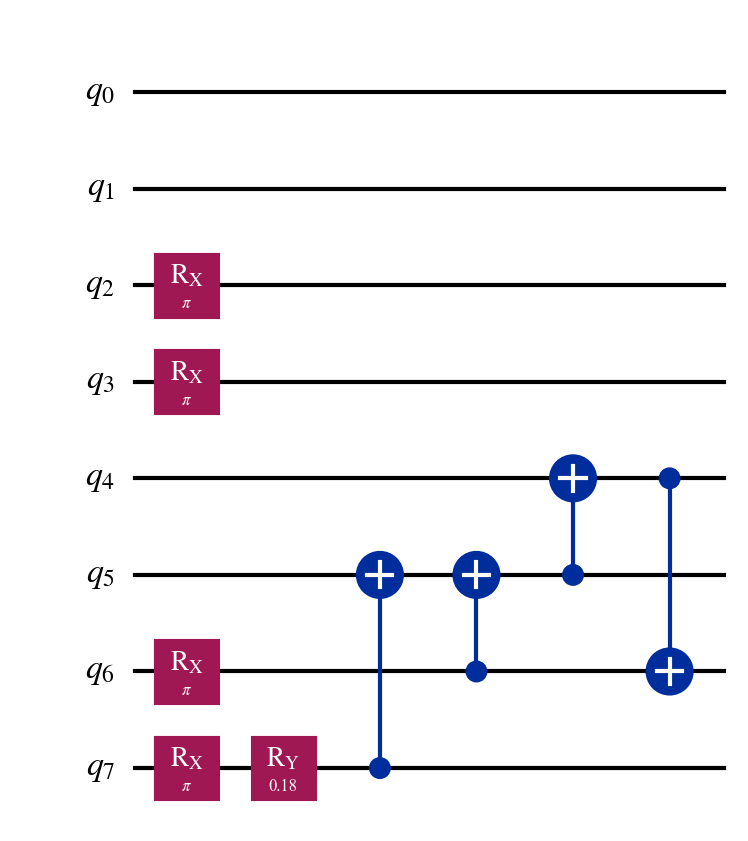

Bond distance: 0.85, Energy: -2.14465


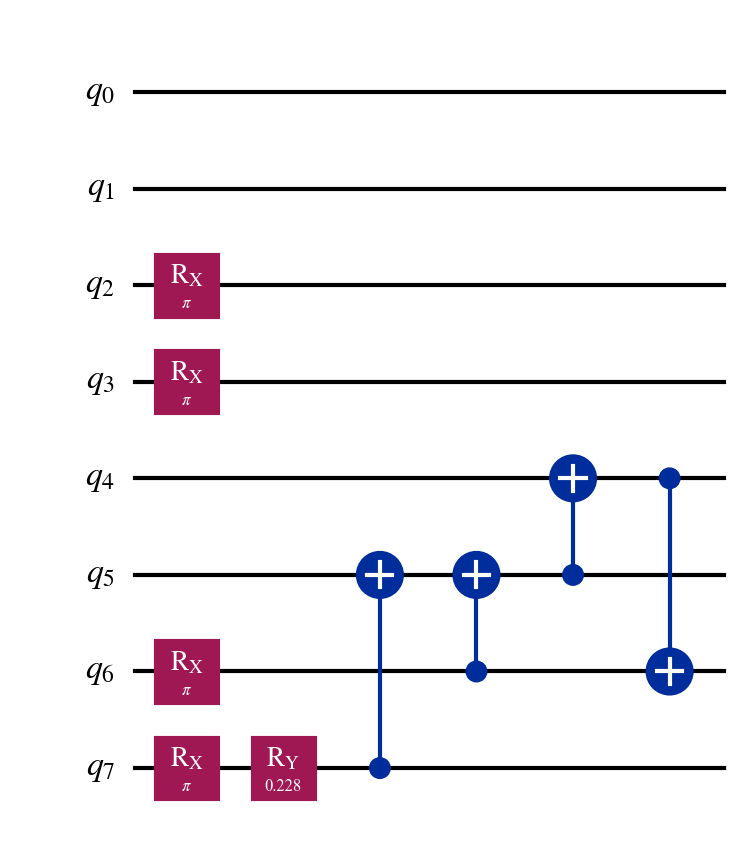

In [30]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from IPython.display import Image, display
from itertools import product

num_qubits = 8

def dictionary():
        #generate self.dictionary of actions 
        dictionary = dict()
        i = 0    
        #CNOT actions
        for c in range(num_qubits):
            for x in range(num_qubits):
                #no CNOT(0,0), CNOT(1,1),..
                if c!=x:
                    dictionary[i] =  [c, x, num_qubits, 0]
                    i += 1
        cnot_count_total=i-1
        #Rotation gate actions
        for r, h in product(range(num_qubits),
                range(1, 4)):
            dictionary[i] = [num_qubits, 0, r, h]
            i += 1

        return dictionary

     
#This function applies the chosen action (=gate) on the state:
def step(chosed_action,chosed_angle,current_qucircuit):
    if dictionary[chosed_action][0]!=num_qubits:
        current_qucircuit.cx(dictionary[chosed_action][0],dictionary[chosed_action][1])
    
    #Apply rotation-gate if third position of the action array does not equal num_qubit
    elif dictionary[chosed_action][2]!=num_qubits:
        #Which rotation axis? Build parametric circuit
        if dictionary[chosed_action][3]==1:
            current_qucircuit.rx(chosed_angle,dictionary[chosed_action][2])
         
            #print(f'current_qucircuit.rx({chosed_angle},{dictionary[chosed_action][2]})')
        elif dictionary[chosed_action][3]==2:
            current_qucircuit.ry(chosed_angle,dictionary[chosed_action][2])
         
            #print(f'current_qucircuit.ry({chosed_angle},{dictionary[chosed_action][2]})')
        elif dictionary[chosed_action][3]==3:
            current_qucircuit.rz(chosed_angle,dictionary[chosed_action][2])
          
            #print(f'current_qucircuit.rz({chosed_angle},{dictionary[chosed_action][2]})')
    return current_qucircuit


# --- Setup ---
session = 3
dictionary= dictionary()
data = np.load("H48_data.npy", allow_pickle=True)
H = [entry[0] for entry in data]
bond_distances = np.array([entry[3] for entry in data])
unseen_results = np.load(f'training_session_{session}/unseen_prediction_{session}.npy', allow_pickle=True)

pred_energy = np.array(list(zip(*unseen_results))[0])
pred_circuit = np.array(list(zip(*unseen_results))[1])
pred_angles = np.array(list(zip(*unseen_results))[2])
pred_bd = np.round(list(zip(*unseen_results))[3], 2)

# Optional: Welche Bondlängen sollen visualisiert werden?
plot_bonds = np.round(np.arange(0.5, 1.55 + 0.01, 0.05), 2)

# --- Hauptschleife ---
fidelities = []
energies = []

for i in range(30,40):
    circuit = pred_circuit[i]
    angles = pred_angles[i]
    bd = pred_bd[i]

    qc = QuantumCircuit(num_qubits)
    qc.rx(np.pi, 2)
    qc.rx(np.pi, 3)
    qc.rx(np.pi, 6)
    qc.rx(np.pi, 7)

    # Energie vor Optimierung (HF-Zustand)
    state = Statevector(qc).data
    E = np.real(np.vdot(state, np.dot(H[i], state)))

    # Aktionen anwenden
    state_before = state
    for k in range(len(circuit)):
        action = circuit[k]
        angle = -1 * angles[k]  # Invertiertes Vorzeichen
        qc = step(action,angle,qc)

        # Zustand nach Gate
        state = Statevector(qc).data

        # Gate redundant? Dann entfernen
        if np.allclose(state, state_before, atol=1e-6):
            qc.data.pop()
        else:
            state_before = state

    # Energie nach Optimierung
    E_opt = np.real(np.vdot(state, np.dot(H[i], state)))
    energies.append(E_opt)

    # Fidelity zwischen letztem Gate-Zustand und Endzustand
    fidelity = np.abs(np.vdot(state_before, state)) ** 2
    fidelities.append(fidelity)

    # Visualisierung (optional, z. B. bei bestimmten Bondlängen)
    if bd in plot_bonds:
        print(f"Bond distance: {bd}, Energy: {E_opt:.5f}")
        filename = f'H4_test_circuit_opt_{bd}.png'
        transpile(qc, basis_gates=['rx', 'ry', 'rz', 'cx'], optimization_level=1)\
            .draw(output="mpl", filename=filename)
        display(Image(filename=filename))